In [1]:
# from https://github.com/linnykos/veloUncertainty/blob/80d0af1e8f784a5eab47df2aaf42bc990ace1b84/code/kevin/Writeup6_simulation/Writeup6_good-scvelo_generate.ipynb

# scvelo virtual environment

import scvelo as scv
import numpy as np
import scanpy as sc
import math

In [ ]:
def generate_data(alpha,
                  beta,
                  gamma,
                  n_obs,
                  n_vars,
                  noise_level,
                  seed,
                  t_max):
    
    # Generate base S/U with Gaussian noise
    adata = scv.datasets.simulation(n_obs=n_obs,
                                    n_vars=n_vars,
                                    t_max=t_max,
                                    alpha=alpha,
                                    beta=beta,
                                    gamma=gamma,
                                    noise_level=noise_level,
                                    random_seed=seed)

    # --- 1) Multiply the values by 50 ---
    scale_factor = 50.0
    # We perform this on the arrays directly
    # Note: We must ensure values are non-negative for Poisson later, 
    # as Gaussian noise 'noise_level' can introduce negatives.
    S_scaled = np.maximum(adata.layers['spliced'] * scale_factor, 0)
    U_scaled = np.maximum(adata.layers['unspliced'] * scale_factor, 0)

    # --- 2) Update "true RNA velocity" ---
    # Calculated on the scaled continuous values (the means)
    adata.layers['true_velocity'] = (beta * U_scaled) - (gamma * S_scaled)

    # --- 3) Sample from Poisson ---
    # We set a seed here to ensure the Poisson noise is also reproducible
    np.random.seed(seed)
    
    # Treat current scaled values as the mean (lambda)
    S_poisson = np.random.poisson(S_scaled).astype(np.float32)
    U_poisson = np.random.poisson(U_scaled).astype(np.float32)

    # Update the layers
    adata.layers['spliced'] = S_poisson
    adata.layers['unspliced'] = U_poisson
    adata.layers['spliced_raw'] = S_poisson.copy()
    adata.layers['unspliced_raw'] = U_poisson.copy()
    
    # Update .X to match spliced (Scanpy uses .X for PCA by default)
    adata.X = S_poisson.copy()

    # --- 4) Compute PCA and moments (No log-norm) ---
    # PCA
    sc.pp.pca(adata)
    
    # Neighbors
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
    
    # Moments (calculates Ms and Mu)
    scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
    
    # Optional: Print quantiles of the new integer counts to check data range
    quantiles = [0, 0.1, 0.5, 0.9, 1]
    quantile_results = np.quantile(adata.X, quantiles)
    print(f"The quantiles {quantiles} of the new Poisson matrix are: {quantile_results}")

    # --- 5) Return adata ---
    return adata

# --- Usage ---
n_obs = 1000
n_vars = 20
t_max = 25
alpha = 5
beta = .3
gamma = .5
noise_level = 2
seed = 520

data = generate_data(alpha=alpha,
                     beta=beta,
                     gamma=gamma,
                     n_obs=n_obs,
                     n_vars=n_vars,
                     noise_level=noise_level,
                     seed=seed,
                     t_max=t_max)

print("Shape:", data.shape)
print("Layers available:", data.layers.keys())

Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
The quantiles [0, 0.1, 0.5, 0.9, 1] of the new Poisson matrix are: [   0.            0.          263.81384277  516.80170288 2377.19335938]
Shape: (1000, 20)
Layers available: KeysView(Layers with keys: unspliced, spliced, true_velocity, spliced_raw, unspliced_raw, Ms, Mu)


In [3]:
data

AnnData object with n_obs × n_vars = 1000 × 20
    obs: 'true_t', 'n_counts'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_gamma', 'true_scaling'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'unspliced', 'spliced', 'true_velocity', 'spliced_raw', 'unspliced_raw', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [4]:
scv.tl.recover_dynamics(data,t_max=25)
scv.tl.velocity_graph(data,vkey="true_velocity")

recovering dynamics (using 1/20 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocity graph (using 1/20 cores)
    finished (0:00:00) --> added 
    'true_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'true_velocity_pca', embedded velocity vectors (adata.obsm)


/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


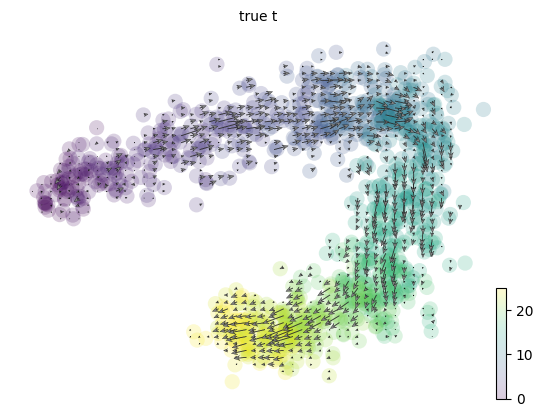

In [5]:
scv.pl.velocity_embedding_grid(data,
                               basis='pca',
                               color="true_t",
                               vkey="true_velocity",
                               arrow_length=2,
                               arrow_size=2,
                               min_mass=10)

/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


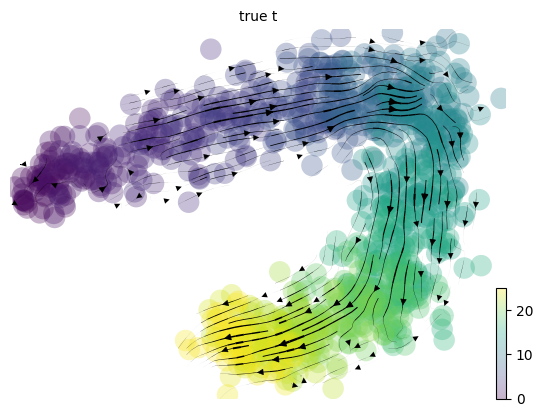

In [6]:
scv.pl.velocity_embedding_stream(data,
                               basis='pca',
                               color="true_t",
                               vkey="true_velocity")

# Now for scVelo

In [7]:
data

AnnData object with n_obs × n_vars = 1000 × 20
    obs: 'true_t', 'n_counts', 'true_velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_gamma', 'true_scaling', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling'
    uns: 'pca', 'neighbors', 'recover_dynamics', 'true_velocity_graph', 'true_velocity_graph_neg', 'true_velocity_params'
    obsm: 'X_pca', 'true_velocity_pca'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'true_velocity', 'spliced_raw', 'unspliced_raw', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_'
    obsp: 'distances', 'connectivities'

In [8]:
scv.tl.recover_dynamics(data)

recovering dynamics (using 1/20 cores)
    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [9]:
scv.tl.velocity(data, mode='stochastic')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [10]:
scv.tl.velocity_graph(data)

computing velocity graph (using 1/20 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


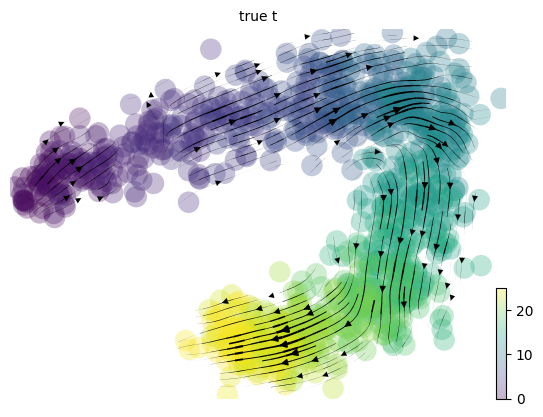

In [11]:
scv.pl.velocity_embedding_stream(data,
                               basis='pca',
                               color="true_t")

# Compute cosine similarity

In [12]:
data

AnnData object with n_obs × n_vars = 1000 × 20
    obs: 'true_t', 'n_counts', 'true_velocity_self_transition', 'velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_gamma', 'true_scaling', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2'
    uns: 'pca', 'neighbors', 'recover_dynamics', 'true_velocity_graph', 'true_velocity_graph_neg', 'true_velocity_params', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'true_velocity_pca', 'velocity_pca'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'true_velocity', 'spliced_raw', 'unspliced_raw', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [13]:
data.layers['true_velocity'].shape

(1000, 20)

In [14]:
data.layers['velocity'].shape

(1000, 20)

Mean Cosine Similarity: 0.4070
Median Cosine Similarity: 0.4644


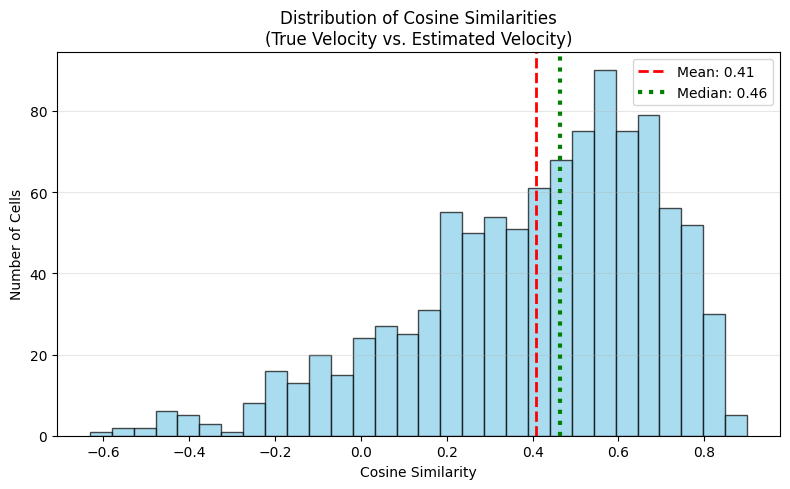

In [ ]:
import matplotlib.pyplot as plt

# 1. Extract the matrices
v_true = data.layers['true_velocity']
v_est = data.layers['velocity']

# 2. Compute Cosine Similarity per cell
# Formula: (A . B) / (|A| * |B|)

# Dot product of the two vectors for each cell (sum over genes/axis 1)
dot_product = np.sum(v_true * v_est, axis=1)

# Magnitudes (L2 norm) of the vectors for each cell
norm_true = np.linalg.norm(v_true, axis=1)
norm_est = np.linalg.norm(v_est, axis=1)

# Calculate similarity
# We add a tiny epsilon to the denominator to prevent division by zero errors
# if a cell happens to have a velocity vector of exactly 0.
epsilon = 1e-8
cosine_sims = dot_product / (norm_true * norm_est + epsilon)

# 3. Calculate statistics
mean_sim = np.mean(cosine_sims)
median_sim = np.median(cosine_sims)

print(f"Mean Cosine Similarity: {mean_sim:.4f}")
print(f"Median Cosine Similarity: {median_sim:.4f}")

# 4. Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(cosine_sims, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add vertical lines
plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_sim:.2f}')
plt.axvline(median_sim, color='green', linestyle=':', linewidth=3, label=f'Median: {median_sim:.2f}')

plt.title('Distribution of Cosine Similarities\n(True Velocity vs. Estimated Velocity)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of Cells')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Exporting data

In [16]:
import scipy.io

In [18]:
spliced_matrix = data.layers['spliced_raw']
unspliced_matrix = data.layers['unspliced_raw']

import scipy.sparse

# Convert to sparse matrix (csc_matrix is usually preferred by R)
spliced_sparse = scipy.sparse.csc_matrix(data.layers['spliced_raw'])
unspliced_sparse = scipy.sparse.csc_matrix(data.layers['unspliced_raw'])

# Write to .mtx
scipy.io.mmwrite('/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/simulation/spliced.mtx', spliced_sparse)
scipy.io.mmwrite('/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/simulation/unspliced.mtx', unspliced_sparse)

In [19]:
data.write_h5ad('/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/simulation/adata.h5ad')